In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [ ]:
df = pd.read_csv('df_298_cleaned_filtered_1 (w_entropy).csv')
columns_to_drop = ['Enthalpy_BCC', 'Enthalpy_HCP', 'G_RT_BCC', 'G_RT_HCP' , 'dG_RT_(BCC - FCC)', 'dG_RT_(HCP - FCC)', 'dG_RT_(BCC - HCP)', 'dG_AT_(BCC - FCC)', 'dG_AT_(HCP - FCC)', 'dG_AT_(BCC - HCP)', 'H_RT_BCC', 'H_RT_HCP' ]
df = df.drop(columns = columns_to_drop, axis = 1)
df= df.drop(columns = 'phase_fraction_hcp', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   C(at%)                 816 non-null    float64
 1   Al(at%)                816 non-null    float64
 2   V(at%)                 816 non-null    float64
 3   Cr(at%)                816 non-null    float64
 4   Mn(at%)                816 non-null    float64
 5   Fe(at%)                816 non-null    float64
 6   Co(at%)                816 non-null    float64
 7   Ni(at%)                816 non-null    float64
 8   Cu(at%)                816 non-null    float64
 9   Mo(at%)                816 non-null    float64
 10  Config_Entropy         816 non-null    float64
 11  (0-T)*Entropy          816 non-null    float64
 12  Enthalpy_FCC           816 non-null    float64
 13  Hom_Temp(K)            816 non-null    int64  
 14  R(%)                   816 non-null    float64
 15  Anneal

In [ ]:
X_train = df.drop('YS(Mpa)', axis = 1)
y_train = df['YS(Mpa)']

In [ ]:
'''currently, mol ratios written as a percentage of the whole. Dividing by 100 and multiplying by the
molar mass gives the molar weight with respect to other elements'''

X_train['C(at%)'] = (X_train['C(at%)'] / 100) * 12.01
X_train['Al(at%)'] = (X_train['Al(at%)'] / 100) * 26.98
X_train['V(at%)'] = (X_train['V(at%)'] / 100) * 50.94
X_train['Cr(at%)'] = (X_train['Cr(at%)'] / 100) * 51.99
X_train['Mn(at%)'] = (X_train['Mn(at%)'] / 100) * 54.94
X_train['Fe(at%)'] = (X_train['Fe(at%)'] / 100) * 55.85
X_train['Ni(at%)'] = (X_train['Ni(at%)'] / 100) * 58.69
X_train['Cu(at%)'] = (X_train['Cu(at%)'] / 100) * 63.55
X_train['Mo(at%)'] = (X_train['Mo(at%)'] / 100) * 95.96

In [ ]:
X_train = X_train.rename(columns={
    'C(at%)': 'C(wt)',
    'Al(at%)': 'Al(wt)',
    'V(at%)': 'V(wt)',
'Cr(at%)': 'Cr(wt)',
    'Mn(at%)': 'Mn(wt)',
    'Fe(at%)': 'Fe(wt)',
    'Ni(at%)': 'Ni(wt)',
    'Cu(at%)': 'Cu(wt)',
    'Mo(at%)': 'Mo(wt)',
    'R(%)': 'R',
    'CR(%)': 'CR'
})

In [ ]:
X_train['R'] = (X_train['R'] / 100)
X_train['CR'] = (X_train['CR'] / 100)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized)
X_train_normalized.columns = X_train.columns
X_train_normalized.head()

# y_train needs to be reshaped into a 2D array
y_train_normalized = scaler.fit_transform(y_train.values.reshape(-1, 1)) # Reshape y_train to a 2D array
y_train_normalized = pd.DataFrame(y_train_normalized) # remove unnecessary reshape
y_train_normalized.columns = ['YS(Mpa)'] # Use a list to assign column name
y_train_normalized.head()

,YS(Mpa)
0,0.145299
1,0.145299
2,0.145299
3,0.367521
4,0.367521


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
np.random.seed(10)


# VAE-2D Model
class VAE2D(keras.Model):
    def __init__(self, latent_dim, input_dim, num_classes, **kwargs):
        super(VAE2D, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.encoder_dense1 = keras.layers.Dense(400, activation='sigmoid')
        self.dense_mean = keras.layers.Dense(latent_dim)
        self.dense_log_var = keras.layers.Dense(latent_dim)
        self.classification_output = keras.layers.Dense(num_classes, activation='softmax')

        self.decoder_dense1 = keras.layers.Dense(400, activation='sigmoid')
        self.decoder_dense2 = keras.layers.Dense(input_dim[0], activation='sigmoid')
        self.decoder_output = keras.layers.Dense(np.prod(input_dim), activation='sigmoid')
        self.reshape_layer = keras.layers.Reshape(input_dim)

    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean

    def encode(self, x):
        x = self.encoder_dense1(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

    def decode(self, z):
        z = self.decoder_dense1(z)
        z = self.decoder_dense2(z)
        z = self.decoder_output(z)
        z = self.reshape_layer(z)
        return z

    def classify(self, z):
        return self.classification_output(z)

    def call(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        classification = self.classify(z)
        return reconstructed, classification, mean, log_var

    def get_latent_space(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return z

    def vae_loss(self, x, reconstructed, mean, log_var):
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, reconstructed))
        #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(x, reconstructed), axis=1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1))
        return reconstruction_loss + kl_loss

    def combined_loss(self, x, reconstructed, mean, log_var, labels, classification):
        vae_loss = self.vae_loss(x, reconstructed, mean, log_var)
        classification_loss = keras.losses.sparse_categorical_crossentropy(labels, classification)
        classification_loss = tf.reduce_mean(classification_loss)
        return vae_loss + classification_loss

def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        reconstructed, classification, mean, log_var = model(x)
        loss = model.combined_loss(x, reconstructed, mean, log_var, labels, classification)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss



In [ ]:
'''
# Loss function
def vae_loss(y_true, y_pred, mean, log_var):
    y_true = tf.cast(y_true, tf.float32)
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return tf.cast(reconstruction_loss, tf.float32) + tf.cast(kl_loss, tf.float32)
'''


'\n# Loss function\ndef vae_loss(y_true, y_pred, mean, log_var):\n    y_true = tf.cast(y_true, tf.float32)\n    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))\n    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))\n    return tf.cast(reconstruction_loss, tf.float32) + tf.cast(kl_loss, tf.float32)\n'

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X_train_normalized, y_train_normalized, test_size=0.2, random_state=42)

In [ ]:
train_data.shape

(652, 24)

In [ ]:
vae_autoencoder= VAE2D(input_dim = (24,), latent_dim = 3, num_classes = 1851)

In [ ]:
optimizer = keras.optimizers.SGD()


Epoch 1/10
Batch 1: Loss = 7.799446105957031
Batch 2: Loss = 7.791326999664307
Epoch 2/10
Batch 1: Loss = 7.780989170074463
Batch 2: Loss = 7.772671222686768
Epoch 3/10
Batch 1: Loss = 7.7606096267700195
Batch 2: Loss = 7.75274133682251
Epoch 4/10
Batch 1: Loss = 7.737147331237793
Batch 2: Loss = 7.732503414154053
Epoch 5/10
Batch 1: Loss = 7.713503360748291
Batch 2: Loss = 7.701131343841553
Epoch 6/10
Batch 1: Loss = 7.699458122253418
Batch 2: Loss = 7.688320159912109
Epoch 7/10
Batch 1: Loss = 7.666559219360352
Batch 2: Loss = 7.663628101348877
Epoch 8/10
Batch 1: Loss = 7.651092529296875
Batch 2: Loss = 7.650747776031494
Epoch 9/10
Batch 1: Loss = 7.633206844329834
Batch 2: Loss = 7.621909141540527
Epoch 10/10
Batch 1: Loss = 7.602956771850586
Batch 2: Loss = 7.6078715324401855


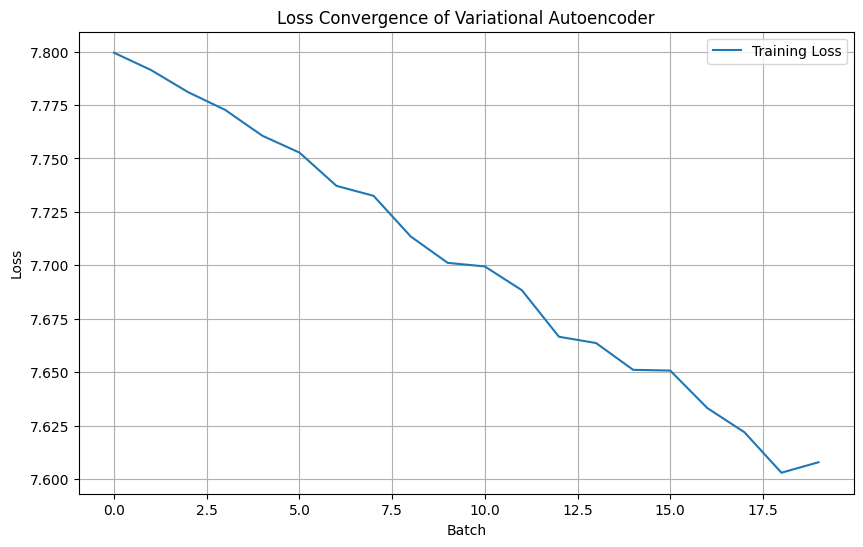

In [ ]:
import matplotlib.pyplot as plt

epochs = 10
batch_size = 468
loss_values = []  # To store loss values for each batch

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        loss = train_step(vae_autoencoder, train_data, train_labels, optimizer)
        loss_values.append(loss.numpy())  # Store the loss value
        print(f"Batch {i // batch_size + 1}: Loss = {loss.numpy()}")

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Convergence of Variational Autoencoder')
plt.legend()
plt.grid()
plt.show()

In [ ]:
latent_train = vae_autoencoder.get_latent_space(train_data)

NameError: name 'latent_space' is not defined

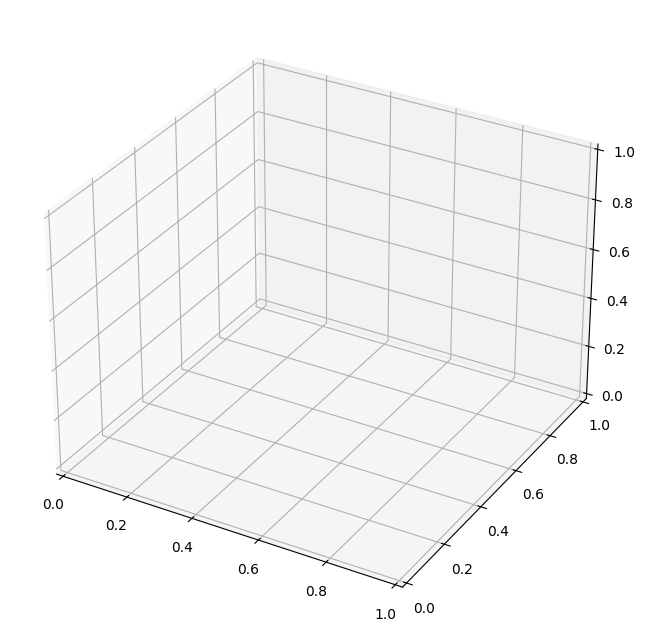

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting



# 3D Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for training data
scatter = ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2],
                     c=train_labels, cmap='coolwarm', alpha=0.7, label='Train')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



tree_reg = DecisionTreeRegressor()
tree_reg.fit(latent_train, train_labels )

latent_test = vae_autoencoder.get_latent_space(test_data)
c_predictions_test = tree_reg.predict(latent_test)

c_predictions_train = tree_reg.predict(latent_train)

predicted_scaled_yield_strength = c_predictions_test.reshape(-1, 1)
print(predicted_scaled_yield_strength.shape)
predicted_yield_strength = scaler.inverse_transform(predicted_scaled_yield_strength)
tree_mse = mean_squared_error(test_labels, c_predictions_test)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
print(predicted_yield_strength)


mae_test = mean_absolute_error(test_labels, c_predictions_test)
mae_train = mean_absolute_error(train_labels, c_predictions_train)

print("mae_test", mae_test)
print("mae_train", mae_train)
print

(164, 1)
[[ 264.]
 [1426.]
 [ 770.]
 [ 155.]
 [1850.]
 [ 243.]
 [ 330.]
 [ 740.]
 [ 320.]
 [ 351.]
 [1100.]
 [ 529.]
 [ 310.]
 [ 310.]
 [ 342.]
 [ 160.]
 [ 943.]
 [ 733.]
 [ 430.]
 [ 550.]
 [ 204.]
 [ 248.]
 [ 740.]
 [ 118.]
 [ 382.]
 [ 207.]
 [ 243.]
 [1424.]
 [1850.]
 [ 493.]
 [ 847.]
 [ 576.]
 [ 491.]
 [ 755.]
 [ 540.]
 [ 305.]
 [ 702.]
 [1108.]
 [ 350.]
 [ 400.]
 [ 733.]
 [1290.]
 [ 733.]
 [ 350.]
 [ 350.]
 [1145.]
 [1613.]
 [ 118.]
 [1658.]
 [ 758.]
 [ 625.]
 [ 930.]
 [ 647.]
 [ 146.]
 [ 517.]
 [ 401.]
 [ 752.]
 [ 243.]
 [ 795.]
 [ 332.]
 [ 783.]
 [ 761.]
 [ 310.]
 [ 539.]
 [ 375.]
 [ 403.]
 [ 702.]
 [1424.]
 [ 634.]
 [ 248.]
 [ 256.]
 [ 227.]
 [ 249.]
 [ 409.]
 [1613.]
 [ 461.]
 [ 331.]
 [ 879.]
 [ 840.]
 [ 783.]
 [ 493.]
 [ 440.]
 [ 179.]
 [1300.]
 [ 360.]
 [ 179.]
 [ 517.]
 [ 351.]
 [ 227.]
 [ 440.]
 [1146.]
 [ 357.]
 [1100.]
 [ 740.]
 [1094.]
 [1502.]
 [ 253.]
 [ 227.]
 [ 545.]
 [ 256.]
 [ 351.]
 [ 470.]
 [ 631.]
 [1100.]
 [1205.]
 [ 234.]
 [1199.]
 [ 199.]
 [1122.]
 [ 540.]
 

<function print>

In [ ]:
# Training step

def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        reconstructed, classification, mean, log_var = model(x)
        loss = model.combined_loss(x, reconstructed, mean, log_var, labels, classification)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [ ]:
# Generate some random data for example purposes
#x_train = np.random.rand(100, 4656, 4).astype(np.float32)
# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

In [ ]:
epochs = 5
batch_size = 32

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(train_data), batch_size):
        x_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        loss = train_step(model, train_data, train_labels, optimizer = optimizer)
        print(f"Batch {i // batch_size + 1}: Loss = {loss.numpy()}")

Epoch 1/5


NameError: name 'model' is not defined

In [ ]:
'''for epoch in range(5):
  loss = train_step(model, train_data, optimizer)
  print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")'''

In [ ]:
latent_space = model.get_latent_space(train_data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Plotting the latent space in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the latent space
ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=y_train, cmap='viridis', marker='o', alpha=0.7)

# Labels and title
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
ax.set_title('3D Latent Space Visualization')

plt.show()